# Workbook for MIMIC Hypercapnia Presenting Chief Concern Analysis

Requirements: 

- MIMIC tabular dataset including columns
- natural language processing with ModernBERT

In [1]:
import sys, site, pprint, subprocess, importlib.util as iu
print("Python:", sys.version)
print("Executable:", sys.executable)
print("Site-packages:")
pprint.pprint(site.getsitepackages())
print("Matplotlib present?", iu.find_spec("matplotlib") is not None)


Python: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:52:34) [Clang 18.1.8 ]
Executable: /opt/anaconda3/envs/mimiciv-tabular/bin/python
Site-packages:
['/opt/anaconda3/envs/mimiciv-tabular/lib/python3.11/site-packages']
Matplotlib present? True


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

working_dir = r'/Users/reblocke/Research/Hypercap-CC-NLP/MIMIC tabular data/ICD Only (Legacy)'
# working_dir = # r'/Users/mac/Desktop/Hyper Ca/Excel/'

# Define the full path to the Excel file
file_path = os.path.join(working_dir, r'MIMIC_hypercap.xlsx')

# Read the first sheet (index 0) into a DataFrame
df = pd.read_excel(file_path, sheet_name=0, engine='openpyxl')

# Display the first few rows
df.head()


,subject_id,stay_id,ICD10_J9602,ICD10_J9612,ICD10_J9622,ICD10_J9692,ICD10_E662,ICD9_27803,hadm_id,any_hypercap_icd,...,poc_paco2_time,poc_ph,poc_ph_uom,poc_ph_time,poc_vbg_paco2,poc_vbg_paco2_uom,poc_vbg_paco2_time,poc_vbg_ph,poc_vbg_ph_uom,poc_vbg_ph_time
0,10049041,39603879.0,1,0,0,0,0,0,25320808.0,1,...,2163-12-19 14:51:00,NaN,NaN,NaT,70.0,mmHg,2163-12-19 14:51:00,NaN,NaN,NaN
1,10157454,30090252.0,0,0,0,1,0,0,27280709.0,1,...,2182-05-05 07:51:00,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
2,10221321,32594629.0,1,0,0,0,0,0,25069369.0,1,...,2127-08-31 15:46:00,NaN,NaN,NaT,62.0,mmHg,2127-08-31 15:46:00,NaN,NaN,NaN
3,10313626,30814731.0,1,0,0,0,0,0,25229838.0,1,...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN
4,10338515,36620377.0,1,0,0,0,0,0,23508373.0,1,...,2143-11-19 06:34:00,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN


## Data cleaning

In [4]:
# Optional: Strip whitespace from column names
df.columns = df.columns.str.strip()

Create parsimonious race/ethnicity list (in accordance with CDC guidelines)

In [5]:
race_map = {
    'WHITE': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',

    'BLACK/AFRICAN AMERICAN': 'Black or African American',
    'BLACK/CAPE VERDEAN': 'Black or African American',
    'BLACK/AFRICAN': 'Black or African American',
    'BLACK/CARIBBEAN ISLAND': 'Black or African American',

    'AMERICAN INDIAN/ALASKA NATIVE': 'American Indian or Alaska Native',

    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - SOUTH EAST ASIAN': 'Asian',
    'ASIAN - KOREAN': 'Asian',

    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Native Hawaiian or Other Pacific Islander',

    # Optional: you can map unknowns and Latinos to a separate category or exclude
    'UNKNOWN': 'Other/Unknown',
    'UNABLE TO OBTAIN': 'Other/Unknown',
    'PATIENT DECLINED TO ANSWER': 'Other/Unknown',

    'PORTUGUESE': 'Other/Unknown',
    'OTHER': 'Other/Unknown',
    'SOUTH AMERICAN': 'Other/Unknown',

    # Hispanic categories → Optional: map to Other/Unknown, or include as separate analysis
    'HISPANIC OR LATINO': 'Other/Unknown',
    'HISPANIC/LATINO - PUERTO RICAN': 'Other/Unknown',
    'HISPANIC/LATINO - DOMINICAN': 'Other/Unknown',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Other/Unknown',
    'HISPANIC/LATINO - GUATEMALAN': 'Other/Unknown',
    'HISPANIC/LATINO - CUBAN': 'Other/Unknown',
    'HISPANIC/LATINO - COLUMBIAN': 'Other/Unknown',
}

df['race_collapsed'] = df['race'].map(race_map).fillna('Other/Unknown')
collapsed_counts = df['race_collapsed'].value_counts()
print(collapsed_counts)


race_collapsed
White                                        3026
Black or African American                     903
Other/Unknown                                 886
Asian                                         114
American Indian or Alaska Native               12
Native Hawaiian or Other Pacific Islander       6
Name: count, dtype: int64


In [6]:
race_counts = df['race_collapsed'].value_counts()
race_percentages = (race_counts / race_counts.sum() * 100).round(1)

race_table1 = pd.DataFrame({
    'Race': race_counts.index,
    'N': race_counts.values,
    'Percent (%)': race_percentages.values
})

race_table1


,Race,N,Percent (%)
0,White,3026,61.2
1,Black or African American,903,18.3
2,Other/Unknown,886,17.9
3,Asian,114,2.3
4,American Indian or Alaska Native,12,0.2
5,Native Hawaiian or Other Pacific Islander,6,0.1


Add hypercapnia marker (hypercapnia by blood gas)

In [ ]:
# This marks patients as “hypercapnic” if their arterial or venous pCO₂ is above 45 or 50 mmHg, regardless of which test was present.
df["hypercapnic"] = (df["poc_paco2"] > 45) | (df["poc_vbg_paco2"] > 50)

Explore and Clean Chief Complaints

In [7]:
df["chief_complaint"].value_counts().head(30)

chief_complaint
Dyspnea                            301
Respiratory distress                76
Dyspnea, Transfer                   63
Dyspnea, Hypoxia                    60
Hypoxia                             54
Altered mental status               52
Chest pain, Dyspnea                 35
s/p Fall                            27
Weakness                            22
Abd pain                            22
DYSPNEA                             20
Transfer                            20
Chest pain                          20
s/p Fall, Transfer                  19
Abd pain, Transfer                  18
RESP DISTRESS                       18
Respiratory distress, Transfer      18
Unresponsive                        17
SHORTNESS OF BREATH                 16
SOB                                 15
Abnormal labs                       15
Altered mental status, Transfer     15
Cardiac arrest                      13
Dyspnea on exertion                 13
Altered mental status, Hypoxia      13
Lethargy 

In [8]:
complaint_counts = df['chief_complaint'].value_counts()
print(complaint_counts.head(20))  # Top 20 complaints

chief_complaint
Dyspnea                           301
Respiratory distress               76
Dyspnea, Transfer                  63
Dyspnea, Hypoxia                   60
Hypoxia                            54
Altered mental status              52
Chest pain, Dyspnea                35
s/p Fall                           27
Weakness                           22
Abd pain                           22
DYSPNEA                            20
Transfer                           20
Chest pain                         20
s/p Fall, Transfer                 19
Abd pain, Transfer                 18
RESP DISTRESS                      18
Respiratory distress, Transfer     18
Unresponsive                       17
SHORTNESS OF BREATH                16
SOB                                15
Name: count, dtype: int64


In [9]:
# Lowercase, remove punctuation, strip whitespace
# TODO: may not want to remove punctuation yet - as we might want to use this for 
df["clean_complaint"] = (
    df["chief_complaint"]
    .astype(str)
    .str.lower()
    .str.strip()
    #.str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
)

In [10]:
top_labels = df["clean_complaint"].value_counts().nlargest(15).index
df["complaint_label"] = df["clean_complaint"].apply(lambda x: x if x in top_labels else "other")

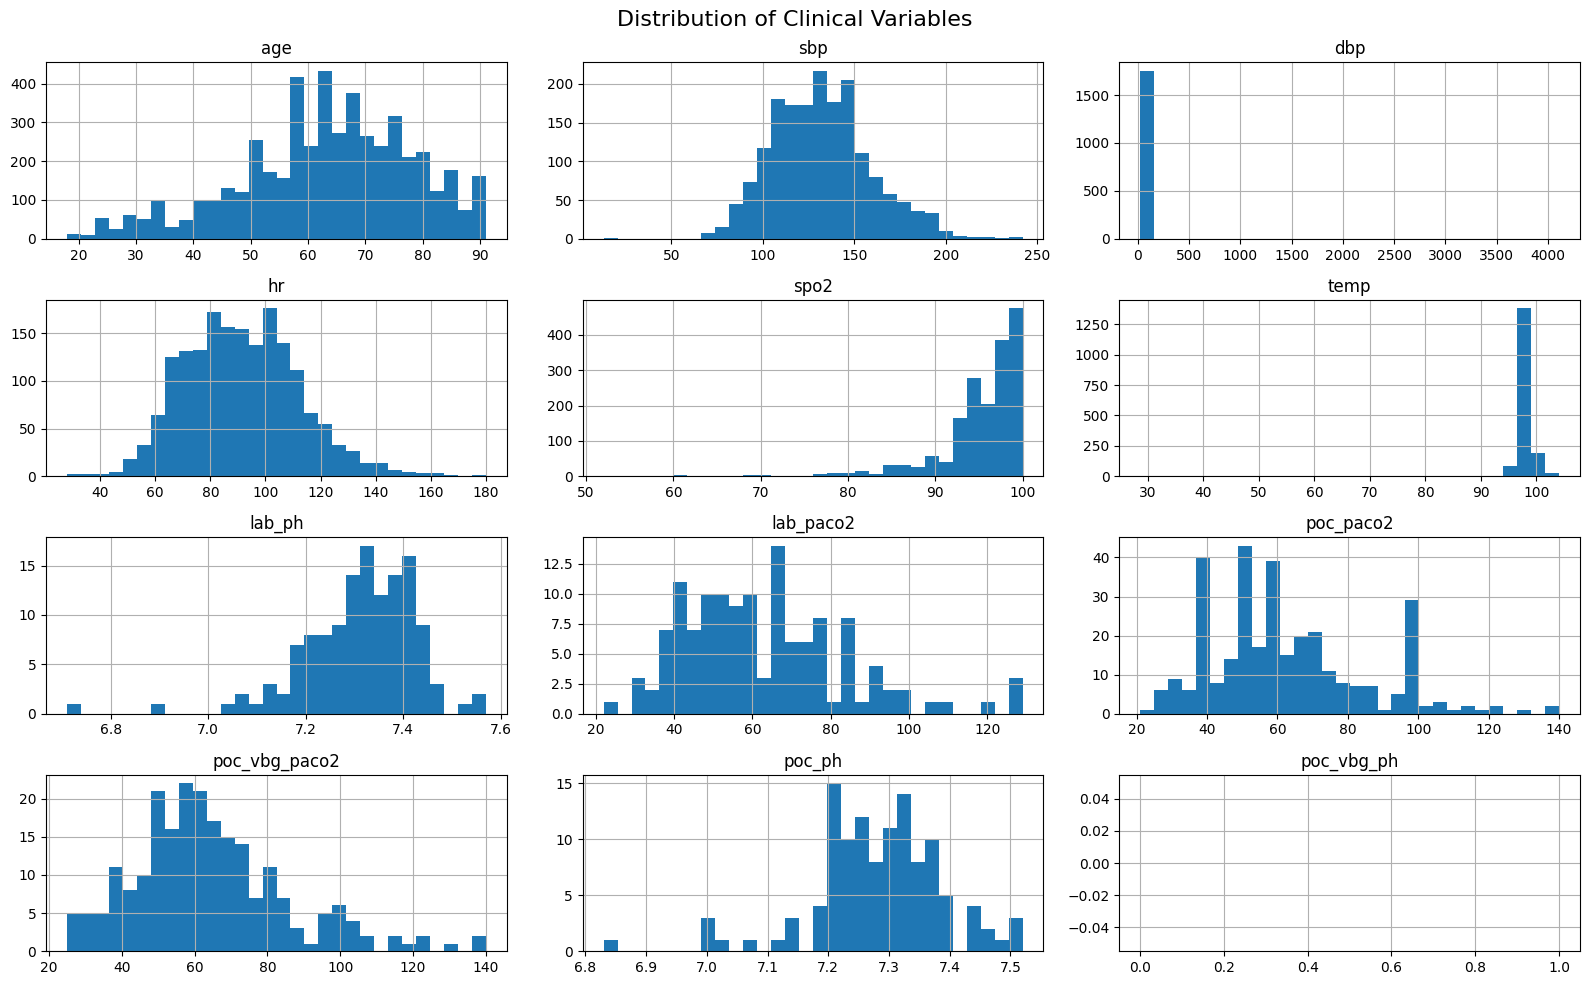

In [11]:
cols = [
    "age", "sbp", "dbp", "hr", "spo2", "temp",
    "lab_ph", "lab_paco2",
    "poc_paco2", "poc_vbg_paco2",
    "poc_ph", "poc_vbg_ph",
]

subset = df.filter(items=cols)      # keeps only existing columns
subset.describe()
subset.isna().sum().sort_values(ascending=False)

df[cols].hist(bins=30, figsize=(16, 10))
plt.suptitle("Distribution of Clinical Variables", fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
df["chief_complaint"].value_counts().head(30)


chief_complaint
Dyspnea                            301
Respiratory distress                76
Dyspnea, Transfer                   63
Dyspnea, Hypoxia                    60
Hypoxia                             54
Altered mental status               52
Chest pain, Dyspnea                 35
s/p Fall                            27
Weakness                            22
Abd pain                            22
DYSPNEA                             20
Transfer                            20
Chest pain                          20
s/p Fall, Transfer                  19
Abd pain, Transfer                  18
RESP DISTRESS                       18
Respiratory distress, Transfer      18
Unresponsive                        17
SHORTNESS OF BREATH                 16
SOB                                 15
Abnormal labs                       15
Altered mental status, Transfer     15
Cardiac arrest                      13
Dyspnea on exertion                 13
Altered mental status, Hypoxia      13
Lethargy 

Dates

In [13]:
# Ensure datetime format
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

# Calculate LOS in days
df['los_days'] = (df['dischtime'] - df['admittime']).dt.total_seconds() / (60 * 60 * 24)

# If you want LOS in hours instead:
df['los_hours'] = (df['dischtime'] - df['admittime']).dt.total_seconds() / 3600

df[['admittime', 'dischtime', 'los_days']].head()

,admittime,dischtime,los_days
0,2163-12-19 14:48:00,2164-01-08 17:32:00,20.113889
1,2182-05-05 05:47:00,2182-05-30 18:30:00,25.529861
2,2127-08-31 14:47:00,2127-09-04 14:41:00,3.995833
3,2194-10-06 18:19:00,2194-10-16 19:17:00,10.040278
4,2143-11-19 05:37:00,2143-11-19 21:50:00,0.675694


In [14]:

df['los_days'].describe()

count    4943.000000
mean       17.452451
std        28.282237
min        -0.699306
25%         4.971528
50%         9.871528
75%        20.330556
max       515.562500
Name: los_days, dtype: float64

In [15]:
df[['admittime', 'dischtime', 'los_days']].sort_values(by='los_days', ascending=False).head(10)

,admittime,dischtime,los_days
221,2190-05-23 01:00:00,2191-10-20 14:30:00,515.562500
220,2190-05-23 01:00:00,2191-10-20 14:30:00,515.562500
216,2190-05-23 01:00:00,2191-10-20 14:30:00,515.562500
217,2190-05-23 01:00:00,2191-10-20 14:30:00,515.562500
218,2190-05-23 01:00:00,2191-10-20 14:30:00,515.562500
219,2190-05-23 01:00:00,2191-10-20 14:30:00,515.562500
1137,2163-02-19 14:51:00,2163-10-24 04:40:00,246.575694
1140,2163-02-19 14:51:00,2163-10-24 04:40:00,246.575694
1135,2163-02-19 14:51:00,2163-10-24 04:40:00,246.575694
1136,2163-02-19 14:51:00,2163-10-24 04:40:00,246.575694


Acuity

In [16]:
# Drop missing acuity values (optional, based on your dataset)
df_acuity = df[df['triage_acuity'].notna()]

# Convert to integer if needed
df_acuity['triage_acuity'] = df_acuity['triage_acuity'].astype(int)

# Frequency count
acuity_counts = df_acuity['triage_acuity'].value_counts().sort_index()

# Percentage calculation
acuity_percentages = (acuity_counts / acuity_counts.sum() * 100).round(1)

# Combine into DataFrame
acuity_table1 = pd.DataFrame({
    'Triage Acuity': acuity_counts.index,
    'N': acuity_counts.values,
    'Percent (%)': acuity_percentages.values
})

acuity_table1


/var/folders/kc/jkd3yt1s0436pgb396mzmmn00000gn/T/ipykernel_87532/33755821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acuity['triage_acuity'] = df_acuity['triage_acuity'].astype(int)


,Triage Acuity,N,Percent (%)
0,1,726,32.9
1,2,1116,50.6
2,3,363,16.5
3,4,1,0.0


Age

In [17]:
# Define age bins and labels
age_bins = [0, 39, 64, 79, float('inf')]
age_labels = ['18–39 (Young Adult)', '40–64 (Middle-aged)', '65–79 (Older Adult)', '80+ (Elderly)']

# Create new column for age group
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)

# Calculate frequency
age_counts = df['age_group'].value_counts().sort_index()

# Calculate percentage
age_percent = (age_counts / age_counts.sum() * 100).round(1)

# Create summary DataFrame
age_table = pd.DataFrame({
    'Age Group': age_counts.index,
    'N': age_counts.values,
    'Percent (%)': age_percent.values
})

# Display
import IPython.display as display
display.display(age_table)


,Age Group,N,Percent (%)
0,18–39 (Young Adult),390,7.9
1,40–64 (Middle-aged),2119,42.8
2,65–79 (Older Adult),1753,35.4
3,80+ (Elderly),685,13.8


## Data Analysis

Manual visualizations

In [18]:
# Count and percent by group
sex_counts = pd.crosstab(df["sex"], df["hypercapnic"])
sex_props = pd.crosstab(df["sex"], df["hypercapnic"], normalize='columns') * 100

# Combine into one table
sex_summary = pd.concat([sex_counts, sex_props], axis=1, keys=["Count", "Percent"])
print(sex_summary)

# Frequency count
sex_counts = df['sex'].value_counts()

# Percentage calculation
sex_percentages = (sex_counts / sex_counts.sum() * 100).round(1)

# Combine into a DataFrame
sex_table1 = pd.DataFrame({
    'Sex': sex_counts.index,
    'N': sex_counts.values,
    'Percent (%)': sex_percentages.values
})

sex_table1

            Count          Percent           
hypercapnic False True       False      True 
sex                                          
F            2478   122  52.734624  49.193548
M            2221   126  47.265376  50.806452


,Sex,N,Percent (%)
0,F,2600,52.6
1,M,2347,47.4


PaCO2 and VBG CO2 among patients who had it checked.

Mean point-of-care PaCO2 (arterial): 62.50155763239876
Mean venous blood gas PaCO2: 64.20535714285714


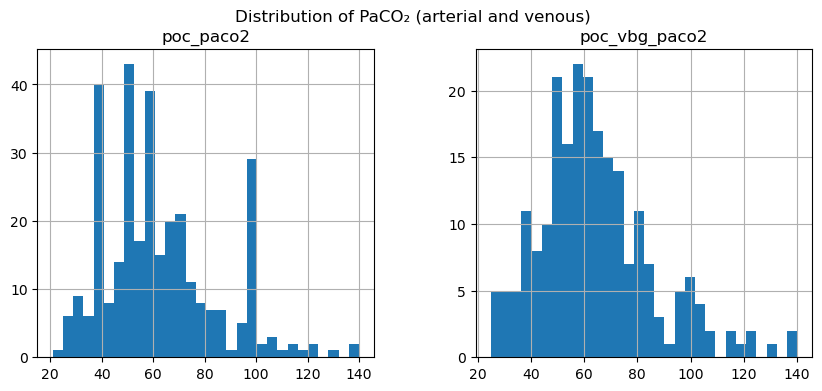

In [19]:
# Calculate mean PaCO2 from arterial and venous blood gases
mean_poc_paco2 = df["poc_paco2"].mean()
mean_vbg_paco2 = df["poc_vbg_paco2"].mean()

print("Mean point-of-care PaCO2 (arterial):", mean_poc_paco2)
print("Mean venous blood gas PaCO2:", mean_vbg_paco2)

df[["poc_paco2", "poc_vbg_paco2"]].hist(bins=30, figsize=(10, 4))
plt.suptitle("Distribution of PaCO₂ (arterial and venous)")
plt.show()


### Creating a table 1

In [20]:
# ── imports ──────────────────────────────────────────────────────────
import pandas as pd
from tableone import TableOne
from IPython.display import display 

# ── user settings ────────────────────────────────────────────────────
NUM_VARS = [
    'age', 'los_hrs', 'hr', 'sbp', 'dbp', 'rr', 'spo2', 'temp',
    'lab_paco2', 'poc_vbg_paco2', 'lab_ph', 'poc_vbg_ph',
]
CAT_VARS = ['sex', 'race_collapsed', 'died', 'triage_acuity', 'chief_complaint']
GROUP    = 'hypercapnic'                    # None → overall only

# ── prep ─────────────────────────────────────────────────────────────
num_present = [c for c in NUM_VARS if c in df.columns]
cat_present = [c for c in CAT_VARS if c in df.columns]
df[cat_present] = df[cat_present].astype(str)

t1 = TableOne(
    df,
    columns     = num_present + cat_present,
    categorical = cat_present,
    groupby     = GROUP if GROUP in df.columns else None,
    pval        = False,
    missing     = False,
)

tbl = t1.tableone             # pull the DataFrame

# ── flatten the row index into Variable / Level ──────────────────────
if isinstance(tbl.index, pd.MultiIndex):
    tbl = tbl.reset_index(names=['Variable', 'Level'])
else:
    tbl = tbl.reset_index(names=['Variable'])
    if tbl['Variable'].str.contains('=').any():      # e.g. "sex = Female"
        split = tbl['Variable'].str.split('=', 1, expand=True)
        tbl[['Variable', 'Level']] = split
    else:
        tbl['Level'] = ''

tbl['Variable'] = tbl['Variable'].str.strip().ffill()
tbl['Level']    = tbl['Level'].str.strip()

# ── flatten column names (handles stratified tables) ─────────────────
def _flat(col):
    if isinstance(col, tuple):
        # ('Grouped by hypercapnic', 'False') → 'hypercapnic_False'
        return '_'.join(str(c).replace('Grouped by ', '').strip() for c in col if c)
    return col

tbl.columns = [_flat(c) for c in tbl.columns]

# ── final ordering & export ──────────────────────────────────────────
stats_cols = [c for c in tbl.columns if c not in ('Variable', 'Level')]
clean = tbl[['Variable', 'Level'] + stats_cols]

clean.to_csv("table1_cleaned.csv", index=False)
display(clean.head())    # comment out if running outside Jupyter

/opt/anaconda3/lib/python3.11/site-packages/tableone/tables.py:392: RuntimeWarning: 'poc_vbg_ph' has all non-numeric values. Consider including it in the list of categorical variables.
  non_continuous_warning(column)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/opt/anaconda3/lib/python3.11/site-packages/tableone/tableone.py:596: RuntimeWarning: Mean of empty slice
  return f.format(np.nanmean(x.values), self.statistics._std(x, self._ddof))  # type: ignore
/opt/anaconda3/lib/python3.11/site-packages/tableone/tables.py:392: RuntimeWarning: 'poc_vbg_ph' has all non-numeric values. Consider including it in the list of categorical variables.
  non_continuous_warning(column)
/opt/anaconda

,Variable,Level,hypercapnic_Overall,hypercapnic_False,hypercapnic_True
0,n,,4947,4699,248
1,"age, mean (SD)",,63.2 (15.2),63.0 (15.2),65.7 (14.6)
2,"los_hrs, mean (SD)",,418.9 (678.8),426.1 (693.9),281.3 (216.3)
3,"hr, mean (SD)",,91.2 (20.6),91.1 (20.5),92.6 (21.5)
4,"sbp, mean (SD)",,132.2 (26.8),132.5 (26.8),128.6 (26.3)


In [21]:
# Columns to include in Table 1
cols = [
    "age", "sex", "race",
    "sbp", "dbp", "hr", "temp", "spo2",
    "lab_ph", "lab_co2", "lab_paco2",
    "poc_paco2", "poc_vbg_paco2",
    "triage_acuity", "los_hrs", "died"
]

# Keep only columns that exist in the data
table_vars = [col for col in cols if col in df.columns]

# Create basic summary statistics
summary = df[table_vars].describe(include='all').T

# Add missingness as a column
summary["missing (%)"] = df[table_vars].isnull().mean() * 100

# Reorder columns (optional)
columns_order = ["count", "mean", "std", "min", "25%", "50%", "75%", "max", "missing (%)"]
summary = summary[[col for col in columns_order if col in summary.columns]]

# Display the result
print(summary)


                count        mean         std        min         25%  \
age            4947.0   63.180109   15.170766       18.0        54.0   
sex              4947         NaN         NaN        NaN         NaN   
race             4943         NaN         NaN        NaN         NaN   
sbp            1768.0  132.224548   26.756906       13.0       113.0   
dbp            1759.0   77.976123  103.238337       23.0        62.0   
hr             1787.0   91.217124   20.611722       28.0        76.0   
temp           1689.0   97.699645    4.915691       28.6        97.4   
spo2           1763.0   95.152014    5.566299       52.0        94.0   
lab_ph          131.0    7.311756     0.11947       6.71        7.25   
lab_paco2       131.0   63.122137    20.92809       22.0        47.5   
poc_paco2       321.0   62.501558   22.454137       21.0        48.0   
poc_vbg_paco2   224.0   64.205357   21.484853       25.0        50.0   
triage_acuity    4947         NaN         NaN        NaN        

In [22]:
# Columns you want to summarize
numerical_vars = ["age", "sbp", "dbp", "hr", "temp", "spo2", "poc_paco2", "poc_vbg_paco2", "lab_ph", "los_hrs"]
numerical_vars = [col for col in numerical_vars if col in df.columns]

# Grouped summary
stratified_summary = df.groupby("hypercapnic")[numerical_vars].agg(["mean", "std", "median", "min", "max", "count"])

print(stratified_summary)


                   age                                         sbp             \
                  mean        std median min max count        mean        std   
hypercapnic                                                                     
False        63.044903  15.187865   64.0  18  91  4699  132.542717  26.780367   
True         65.741935  14.638074   66.5  19  91   248  128.553191  26.300306   

                          ... lab_ph                       los_hrs  \
            median   min  ... median   min   max count        mean   
hypercapnic               ...                                        
False        131.0  13.0  ...  7.340  6.71  7.57   115  426.127082   
True         130.0  71.0  ...  7.225  7.13  7.54    16  281.260148   

                                                                    
                    std      median        min           max count  
hypercapnic                                                         
False        693.945459  237.716667 

In [23]:
# List your categorical variables
categorical_vars = ["sex", "race", "triage_acuity", "died"]
categorical_vars = [col for col in categorical_vars if col in df.columns]

# Choose stratification variable (e.g., hypercapnic or died)
group_col = "hypercapnic"  # or "died", etc.

# Loop through each categorical variable
for var in categorical_vars:
    print(f"\n🔹 {var} stratified by {group_col}:\n")

    # Counts
    counts = pd.crosstab(df[var], df[group_col])

    # Percentages
    percents = pd.crosstab(df[var], df[group_col], normalize='columns') * 100

    # Combine counts and percents
    summary = pd.concat([counts, percents], axis=1, keys=["Count", "Percent"])
    
    # Display
    print(summary.round(1))



🔹 sex stratified by hypercapnic:

            Count       Percent      
hypercapnic False True    False True 
sex                                  
F            2478   122    52.7  49.2
M            2221   126    47.3  50.8

🔹 race stratified by hypercapnic:

                                          Count       Percent      
hypercapnic                               False True    False True 
race                                                               
AMERICAN INDIAN/ALASKA NATIVE                11     1     0.2   0.4
ASIAN                                        36     1     0.8   0.4
ASIAN - ASIAN INDIAN                          4     0     0.1   0.0
ASIAN - CHINESE                              48     7     1.0   2.8
ASIAN - KOREAN                                3     0     0.1   0.0
ASIAN - SOUTH EAST ASIAN                     18     1     0.4   0.4
BLACK/AFRICAN                                48     4     1.0   1.6
BLACK/AFRICAN AMERICAN                      714    43    15

### Natural Language Pre-processing

This list combines the different calls that you had, and pulls an abbreviations list from Meta to replace all the abbreviations. 

In [24]:
# ────────────────────────────────────────────────────────────────────────────
# ED chief-complaint normalizer (consolidated config + robust pipeline)
# ────────────────────────────────────────────────────────────────────────────
from __future__ import annotations
import csv, io, re, zipfile, requests
from pathlib import Path
from typing import List, Callable

import ftfy, pandas as pd, spacy
from symspellpy.symspellpy import SymSpell, Verbosity

# ----------------------------- CONFIG ---------------------------------------
CC_CFG = {
    # Where to fetch the abbreviation inventory once (Zenodo ZIP)
    "meta_zip_url": (
        "https://zenodo.org/records/4567594/files/"
        "lisavirginia/clinical-abbreviations-v1.0.2.zip?download=1"
    ),
    "meta_zip_path": Path("clinical-abbreviations-v1.0.2.zip"),

    # Column name aliases we’ll accept when scanning inventory tables
    "short_keys": {"sf", "abbr", "abbrev", "abbreviation", "short", "short_form", "shortform", "acronym"},
    "long_keys":  {"lf", "expansion", "definition", "sense", "long", "long_form", "longform"},

    # Protected slash tokens (don’t split on the slash)
    "protect_slash": ("n/a", "n/v", "n/v/d", "s/p", "w/", "w/o", "h/o", "c/o"),

    # Segment-level curated overrides (whole segment equals key)
    "segment_overrides": {
        "n/v":   "nausea vomiting",
        "n/v/d": "nausea vomiting diarrhea",
        "nvd":   "nausea vomiting diarrhea",
        "w/":    "with",
        "w/o":   "without",
        "s/p":   "status post",
        "h/o":   "history of",
        "c/o":   "complains of",
        # injury mechanisms & admin shorthand commonly seen in CC lines
        "mva":   "motor vehicle accident",
        "mvc":   "motor vehicle collision",
        "ped vs auto": "pedestrian struck by vehicle",
        "gsw":   "gunshot wound",
        "sa":    "sexual assault",      # note: ambiguous; prefer explicit triage context
    },

    # Token-level curated overrides (expand inside a segment)
    # In your CC_CFG definition, replace/augment token_overrides with:
    "token_overrides": {
        # cardiopulmonary
        "sob": "shortness of breath",
        "doe": "dyspnea on exertion",
        "cp":  "chest pain",
        "palps": "palpitations",
        # neuro
        "ha":  "headache",
        "loc": "loss of consciousness",
        "ams": "altered mental status",
        "sz":  "seizure", "szs": "seizure",
        "cva": "stroke", "tia": "transient ischemic attack",
        # gi/gu
        "abd": "abdominal",
        "rlq": "right lower quadrant", "ruq": "right upper quadrant",
        "llq": "left lower quadrant",  "luq": "left upper quadrant",
        "lbp": "low back pain", "brbpr": "rectal bleeding",
        "hematemesis": "vomiting blood", "hemaemesis": "vomiting blood",
        "uti": "urinary tract infection",
        "dysuria": "painful urination", "hematuria": "blood in urine",
        "nv": "nausea vomiting", "nvd": "nausea vomiting diarrhea",
        # respiratory / infectious
        "sorethroat": "sore throat", "uri": "upper respiratory infection",
        "pna": "pneumonia", "covid": "covid", "flu": "influenza",
        # psych / substance
        "si": "suicidal ideation", "hi": "homicidal ideation",
        "avh": "auditory visual hallucinations",
        "etoh": "alcohol", "od": "overdose",  # contextual 'od' still handled above
        "fb": "foreign body",
        # ob/gyn
        "vag": "vaginal", "vb": "vaginal bleeding", "hg": "hyperemesis gravidarum",
        # >>> Slash forms added as TOKEN overrides so they expand inside segments
        "s/p": "status post",
        "w/":  "with",
        "w/o": "without",
        "h/o": "history of",
        "c/o": "complains of",
        # Also allow these inside segments (not just segment-level)
        "n/v":   "nausea vomiting",
        "n/v/d": "nausea vomiting diarrhea",
    },

    # Contextual token overrides (token -> (predicate, expansion_if_true, expansion_if_false or None))
    # Example: 'od' → 'overdose' unless the segment mentions eye context.
    "contextual_overrides": {
        "od": (
            lambda seg: not re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
            "overdose",
            "right eye"  # if predicate False and 'od' used in eye context
        ),
        "os": (
            lambda seg: re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
            "left eye",
            None
        ),
        "ou": (
            lambda seg: re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
            "both eyes",
            None
        ),
    },

    # Clinical keywords used to keep only relevant long-forms from the Meta-Inventory
    "clinical_keywords": {
        "pain","fever","chill","cough","wheeze","dyspnea","shortness","sputum","hemoptysis",
        "nausea","vomit","diarrhea","constipation","bleeding","rash","swelling","injury","wound",
        "laceration","burn","fracture","sprain","strain","assault","fall","seizure","syncope",
        "weakness","numbness","tingling","headache","dizziness","palpitation","chest","abdominal",
        "flank","pelvic","back","neck","urinary","dysuria","hematuria","pregnan","vaginal",
        "contraction","withdrawal","overdose","intoxication","anxiety","depression","psychosis",
        "sore","throat","ear","eye","dental","tooth","asthma","copd","flu","covid","pneumonia"
    },

    # Missing/administrative segments that should be dropped
    "missing_regex": re.compile(
        r"^(?:n/?a|na|none|unknown|unk|no chief complaint|no complaint|"
        r"not applicable|not available)$"
    ),

    # Discard long-forms that look like biochemistry or long technical names
    "biochem_regex": re.compile(
        r"\b(acetyl|acid|azide|chloride|sulfate|phosphate|benzoate|iodide|"
        r"hydrochloride|glycol|amine|amide|ester|oxide|peroxide|nitrate|nitrite|"
        r"protein|enzyme|receptor|antigen|antibody|gene|genome|polymerase|kinase|"
        r"benz|phenyl|hydroxyl)\b"
    ),

    # Other knobs
    "max_long_words": 5,
    "safe_2char": {"cp","ha","nv","gi","gu","ms","sx","bp","hr","doe","sob","loc"},
}

# -------------------------- spaCy (tokenizer + lemmatizer) ------------------
def get_nlp():
    try:
        return spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])
    except OSError:
        from spacy.cli import download
        print("Downloading spaCy model 'en_core_web_sm' …")
        download("en_core_web_sm")
        return spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])

nlp = get_nlp()

# ------------------- Meta-Inventory → filtered abbr_map ---------------------
def _find_table(zf: zipfile.ZipFile) -> tuple[io.BytesIO, str, str, str]:
    short_keys, long_keys = CC_CFG["short_keys"], CC_CFG["long_keys"]
    for member in zf.namelist():
        if not member.lower().endswith((".csv",".tsv")): 
            continue
        raw = zf.open(member).read()
        head = raw[:8192].decode("utf-8","ignore")
        try:
            sep = csv.Sniffer().sniff(head, delimiters=",\t|;").delimiter
        except csv.Error:
            sep = "," if member.lower().endswith(".csv") else "\t"
        header = next(csv.reader(io.StringIO(head), delimiter=sep))
        cols = [c.strip() for c in header]
        lower = [c.lower() for c in cols]
        s_idx = next((i for i,c in enumerate(lower) if c in short_keys), None)
        l_idx = next((i for i,c in enumerate(lower) if c in long_keys),  None)
        if s_idx is not None and l_idx is not None:
            return io.BytesIO(raw), sep, cols[s_idx], cols[l_idx]
    raise FileNotFoundError("No file with recognisable short/long columns found in archive.")

def _word_count(s: pd.Series) -> pd.Series:
    return s.str.split().map(len)

def build_abbr_map() -> dict[str, str]:
    zip_url, zip_path = CC_CFG["meta_zip_url"], CC_CFG["meta_zip_path"]
    if not zip_path.exists():
        print("⬇️  downloading Meta‑Inventory archive … (~52 MB)")
        zip_path.write_bytes(requests.get(zip_url, timeout=120).content)

    with zipfile.ZipFile(zip_path) as zf:
        buf, sep, short_col_raw, long_col_raw = _find_table(zf)
        print(f"→ using table (sep={repr(sep)}) with short='{short_col_raw}', long='{long_col_raw}'")

    # 1) Read with BOM‑aware encoding and canonicalize column names
    meta = pd.read_csv(
        buf, sep=sep, dtype=str, encoding="utf-8-sig"
    )
    # strip & lowercase ALL column names, remove any embedded BOM if present
    meta.columns = [c.replace("\ufeff", "").strip().lower() for c in meta.columns]

    # 2) Canonical short/long column keys based on what _find_table saw
    sname = short_col_raw.replace("\ufeff", "").strip().lower()
    lname = long_col_raw.replace("\ufeff", "").strip().lower()

    # Sanity check with helpful error
    missing = {k for k in (sname, lname) if k not in meta.columns}
    if missing:
        raise ValueError(
            f"Expected columns {missing} not found. Available columns: {list(meta.columns)}"
        )

    # Keep only the two columns we need; lowercase their CELL values
    meta = meta[[sname, lname]].dropna()
    meta[sname] = meta[sname].astype(str).str.lower()
    meta[lname] = meta[lname].astype(str).str.lower()

    # 3) Filters tuned for ED chief complaints
    ck         = CC_CFG["clinical_keywords"]
    safe2      = CC_CFG["safe_2char"]
    biochem    = CC_CFG["biochem_regex"]
    max_words  = CC_CFG["max_long_words"]
    missing_re = CC_CFG["missing_regex"]

    def _word_count(s: pd.Series) -> pd.Series:
        return s.str.split().map(len)

    # length on short form (allow common 2‑char whitelist)
    meta = meta[(meta[sname].str.len() >= 3) | (meta[sname].isin(safe2))]
    # drop administrative/missing short forms
    meta = meta[~meta[sname].str.fullmatch(missing_re)]
    # alphabetic keys only (allow '/' and '.')
    meta = meta[meta[sname].str.fullmatch(r"[a-z/\.]+")]
    # drop biochemical/very long long‑forms; keep those with clinical keywords
    meta = meta[(~meta[lname].str.contains(biochem)) & (_word_count(meta[lname]) <= max_words)]
    meta = meta[meta[lname].apply(lambda t: any(k in t for k in ck))]

    # 4) Build map
    ab = meta.drop_duplicates(subset=sname).set_index(sname)[lname].to_dict()
    print(f"✓ abbreviation pairs after filtering: {len(ab):,}")
    return ab

abbr_map = build_abbr_map()

# ------------------------- SymSpell (guarded) -------------------------------
sym = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
for term in abbr_map.values():
    sym.create_dictionary_entry(term, 1)

def _spell(tok: str) -> str:
    safe2 = CC_CFG["safe_2char"]
    if len(tok) <= 3 and tok not in safe2:   # leave very short tokens alone
        return tok
    if not tok.isalpha():
        return tok
    s = sym.lookup(tok, Verbosity.CLOSEST, max_edit_distance=2)
    return s[0].term if s else tok

# -------------- token & contextual expansion helpers ------------------------
SEG_OVR  = CC_CFG["segment_overrides"]
TOK_OVR  = CC_CFG["token_overrides"]
CTX_OVR  = CC_CFG["contextual_overrides"]
PROTECT  = CC_CFG["protect_slash"]
MISSING_RE = CC_CFG["missing_regex"]

# Strip leading/trailing punctuation around tokens (keeps letters, digits, slash)
_PUNCT_EDGE = re.compile(r"(^[^\w/]+)|([^\w/]+$)")

def _clean_tok(tok: str) -> str:
    return _PUNCT_EDGE.sub("", tok)

def _expand_tokens(seg: str) -> str:
    """
    Token-level expansion inside a segment.
    Order: contextual overrides → curated token overrides → Meta-Inventory tokens.
    Robust to edge punctuation (e.g., 'cp,' → 'cp').
    """
    out: list[str] = []
    seg_for_ctx = seg  # context predicates look at the raw segment

    for tok in seg.split():
        t = _clean_tok(tok)
        if not t:
            continue

        # contextual override (e.g., 'od' overdose vs right eye)
        if t in CTX_OVR:
            pred, yes, no = CTX_OVR[t]
            if pred(seg_for_ctx):
                out.extend(yes.split()); continue
            if no:
                out.extend(no.split()); continue

        # curated ED overrides (preferred over inventory)
        if t in TOK_OVR:
            out.extend(TOK_OVR[t].split()); continue

        # safe fallback to inventory token expansion
        if t in abbr_map:
            out.extend(abbr_map[t].split()); continue

        out.append(t)
    return " ".join(out)

# duration attachments: e.g., sobx2d → "shortness of breath for 2 days"
_DUR_RE = re.compile(r"\b([a-z]{2,})x(\d{1,3})([dhwm])\b")
_UNIT = {"d":"days","h":"hours","w":"weeks","m":"months"}

def _expand_duration(seg: str) -> str:
    def _repl(m):
        base, n, u = m.group(1), m.group(2), m.group(3)
        return f"{base} for {n} {_UNIT.get(u, '')}".strip()
    return _DUR_RE.sub(_repl, seg)

# ------------------------------ splitter ------------------------------------
# No splitting on '/', only on list/separator tokens:
SPLIT_RE = re.compile(r"\s*(?:[;:,]|(?:\band\b)|\+|&)\s*")

def normalize_cc(raw: str | float) -> List[str]:
    """Expand ED abbreviations (curated + filtered inventory), guard spelling, lemmatize, dedupe."""
    if not isinstance(raw, str) or not raw.strip():
        return []

    txt = ftfy.fix_text(raw).lower().strip()

    # protect common slash tokens (n/v, s/p, etc.) so they survive splitting
    for p in PROTECT:
        txt = txt.replace(p, p.replace("/", "§"))  # sentinel

    chunks, seen = [], set()

    for seg in SPLIT_RE.split(txt):        # no splitting on '/'
        if not seg:
            continue

        seg = seg.replace("§", "/").strip()
        seg = " ".join(seg.split())        # collapse spaces

        # missing/admin segments → drop
        if MISSING_RE.fullmatch(seg):
            continue

        # 1) whole-segment curated overrides (highest priority)
        if seg in SEG_OVR:
            seg = SEG_OVR[seg]
        else:
            # 2) single-token curated overrides take precedence over inventory
            toks = seg.split()
            if len(toks) == 1:
                t = _clean_tok(toks[0])
                if t in TOK_OVR:
                    seg = TOK_OVR[t]
                else:
                    # only now allow an exact whole-segment expansion from the inventory
                    seg = abbr_map.get(seg, seg)
            # (for multi-token segments we skip whole-segment inventory expansion)

        # 3) duration attachments like 'sobx2d' → 'sob for 2 days'
        seg = _expand_duration(seg)

        # 4) token-level expansion (contextual → curated → inventory)
        seg = _expand_tokens(seg)

        # 5) conservative spelling + lemmatization
        tokens = [_spell(t) for t in seg.split()]
        seg = " ".join(t.lemma_ for t in nlp(" ".join(tokens))).strip()

        if seg and seg not in seen:
            chunks.append(seg); seen.add(seg)

    return chunks

# Example:
df["cc_cleaned"]     = df["chief_complaint"].apply(normalize_cc)
df["cc_cleaned_str"] = df["cc_cleaned"].str.join("; ")
df.to_parquet("cleaned_chief_complaints.parquet", index=False)
print("✓ chief complaints cleaned & saved")

→ using table (sep='|') with short='SF', long='LF'


/var/folders/kc/jkd3yt1s0436pgb396mzmmn00000gn/T/ipykernel_37921/3997107381.py:226: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  meta = meta[(~meta[lname].str.contains(biochem)) & (_word_count(meta[lname]) <= max_words)]


✓ abbreviation pairs after filtering: 2,894
✓ chief complaints cleaned & saved


In [25]:
"""Unit tests for normalize_cc() function"""
def _show(x):
    out = normalize_cc(x)
    print(f"{x!r:>32}  →  {out}")
    return out

print("\nSanity checks:")
out1 = _show("N/A")
out2 = _show("na")
out3 = _show("Unknown")
out4 = _show("SOB & cp")
out5 = _show("DOE with exertion")
out6 = _show("N/V + diarrhea")
out7 = _show("abd pain RLQ")
out8 = _show("MVA; gsw to leg; fall w LOC")
out9 = _show("pt w/ fever, s/p fall")
out10= _show("od heroin")
out11= _show("OD eye pain")      # contextual OD → right eye
out12= _show("SOBx2d")

# Assertions (robust to lemmatization)
assert out1 == [] and out2 == [] and out3 == [], "Missing values should be dropped"
assert "shortness of breath" in " ".join(out4), "SOB should expand"
assert "chest pain" in " ".join(out4), "cp should expand"
assert "dyspnea on exertion" in " ".join(out5), "DOE expansion"
assert "diarrhea" in " ".join(out6), "retain diarrhea"
assert any("right lower quadrant" in s for s in out7), "RLQ expansion"
j8 = "; ".join(out8)
assert "motor vehicle" in j8 and "gunshot wound" in j8 and "loss of consciousness" in j8, "injury mechanisms"
assert "status post" in " ".join(out9), "s/p expansion"
assert "overdose" in " ".join(out10), "OD substance context"
assert "right eye" in " ".join(out11), "OD eye context"
assert "for 2 day" in " ".join(out12), "duration attachment"
print("✓ sanity tests passed")


Sanity checks:
                           'N/A'  →  []
                            'na'  →  []
                       'Unknown'  →  []
                      'SOB & cp'  →  ['shortness of breath', 'chest pain']
             'DOE with exertion'  →  ['dyspnea on exertion with exertion']
                'N/V + diarrhea'  →  ['nausea vomit', 'diarrhea']
                  'abd pain RLQ'  →  ['abdominal pain right lower quadrant']
   'MVA; gsw to leg; fall w LOC'  →  ['motor vehicle accident', 'gunshot wound to leg', 'fall w loss of consciousness']
         'pt w/ fever, s/p fall'  →  ['pt with fever', 'status post fall']
                     'od heroin'  →  ['overdose heroin']
                   'OD eye pain'  →  ['right eye eye pain']
                        'SOBx2d'  →  ['shortness of breath for 2 day']
✓ sanity tests passed


In [ ]:
# ============================================================================
# 1‑NN chief‑complaint → 18‑class NHAMCS RVC on‑prem pipeline
# ----------------------------------------------------------------------------
# Requires: pandas, torch, sentence-transformers
# Encoder options:
#   • NeuML/bioclinical-modernbert-base-embeddings  (Sentence‑Transformers ready)
#   • thomas-sounack/BioClinical-ModernBERT-base    (wrap with mean pooling)
# ============================================================================

import torch, pandas as pd
from sentence_transformers import SentenceTransformer, util, models

# ---------------------------------------------------------------------------
# 1.  Choose encoder  (ready Sentence‑Transformers model = least boilerplate)
# ---------------------------------------------------------------------------
MODEL_NAME = "NeuML/bioclinical-modernbert-base-embeddings"
encoder    = SentenceTransformer(MODEL_NAME,
                                 device="cuda" if torch.cuda.is_available() else "cpu",
                                 trust_remote_code=True)

# If you prefer the raw checkpoint, uncomment the block below instead:
# ---------------------------------------------------------------------------
# raw_model = "thomas-sounack/BioClinical-ModernBERT-base"
# word = models.Transformer(raw_model)
# pool = models.Pooling(word.get_word_embedding_dimension(), pooling_mode="mean")
# encoder = SentenceTransformer(modules=[word, pool])
# ---------------------------------------------------------------------------

# -------------------------------------------------------------------
# 2.  Build DESCRIPTIVE prototypes for the 18 NHAMCS RVC categories
#     Texts =  Title + short definition + 3‑8 exemplar complaints.
#     Sources: Vital & Health Statistics S2‑78, NHAMCS 2022 doc.
# -------------------------------------------------------------------
# ==============================
# NHAMCS RVC: ED‑tuned prototypes
# ==============================

# Human‑readable names
RVC_NAME = {
    "RVC-SYM-GEN":  "General symptoms",
    "RVC-SYM-PSY":  "Psychological symptoms",
    "RVC-SYM-NERV": "Nervous system symptoms",
    "RVC-SYM-EYE":  "Eye and ear symptoms",
    "RVC-SYM-CIRC": "Circulatory or lymphatic symptoms",
    "RVC-SYM-RESP": "Respiratory symptoms",
    "RVC-SYM-DIG":  "Digestive system symptoms",
    "RVC-SYM-GU":   "Genitourinary symptoms",
    "RVC-SYM-SKIN": "Skin / hair / nail symptoms",
    "RVC-SYM-MSK":  "Musculoskeletal symptoms",
    "RVC-DIS":      "Known diseases (stated diagnoses)",
    "RVC-DIAG":     "Diagnostic / screening / preventive",
    "RVC-TREAT":    "Treatment / medication",
    "RVC-INJ":      "Injuries & adverse effects",
    "RVC-TEST":     "Abnormal test result",
    "RVC-ADMIN":    "Administrative / legal",
    "RVC-OTHER":    "Other reasons",
    "RVC-UNCL":     "Unclassified / unknown",
}

# Multiple short prototypes per class (improves centroid quality)
RVC_PROTOS = {
    "RVC-SYM-RESP": [
        "Respiratory symptom: shortness of breath",
        "Respiratory symptom: dyspnea",
        "Respiratory symptom: wheeze",
        "Respiratory symptom: cough",
        "Respiratory symptom: hemoptysis",
        "Respiratory symptom: sputum production",
        "Respiratory symptom: noisy breathing",
    ],
    "RVC-SYM-CIRC": [
        "Circulatory symptom: chest pain of suspected cardiac origin",
        "Circulatory symptom: palpitations",
        "Circulatory symptom: hypotension (low blood pressure)",
        "Circulatory symptom: peripheral edema leg swelling ankle swelling",
        "Circulatory symptom: claudication",
    ],
    "RVC-SYM-NERV": [
        "Neurologic symptom: altered mental status",
        "Neurologic symptom: confusion",
        "Neurologic symptom: lethargy decreased responsiveness",
        "Neurologic symptom: slurred speech dysarthria",
        "Neurologic symptom: aphasia word finding difficulty",
        "Neurologic symptom: facial droop",
        "Neurologic symptom: syncope fainting",
        "Neurologic symptom: seizure",
        "Neurologic symptom: headache",
        "Neurologic symptom: dizziness",
        "Neurologic symptom: numbness tingling weakness",
    ],
    "RVC-SYM-DIG": [
        "Digestive symptom: abdominal pain",
        "Digestive symptom: nausea vomiting",
        "Digestive symptom: diarrhea",
        "Digestive symptom: rectal bleeding",
        "Digestive symptom: dysphagia",
        "Digestive symptom: jaundice",
    ],
    "RVC-SYM-GU": [
        "Genitourinary symptom: dysuria painful urination",
        "Genitourinary symptom: urinary frequency urgency",
        "Genitourinary symptom: hematuria blood in urine",
        "Genitourinary symptom: flank pain",
        "Genitourinary symptom: pelvic pain",
        "Genitourinary symptom: vaginal discharge",
    ],
    "RVC-SYM-MSK": [
        "Musculoskeletal symptom: back pain",
        "Musculoskeletal symptom: joint pain",
        "Musculoskeletal symptom: muscle weakness",
        "Musculoskeletal symptom: gait problem",
        # deliberately avoid 'limb swelling' here to reduce edema→MSK errors
    ],
    "RVC-SYM-SKIN": [
        "Skin symptom: rash",
        "Skin symptom: pruritus itching",
        "Skin symptom: cellulitis redness warmth",
        "Skin symptom: wound",
    ],
    "RVC-SYM-EYE": [
        "Eye symptom: eye pain",
        "Eye symptom: blurred vision",
        "Eye symptom: vision loss",
        "Ear symptom: ear pain otalgia",
        "Ear symptom: tinnitus",
        "Ear symptom: hearing loss",
        "Ear symptom: ear discharge",
        "Vestibular symptom: vertigo spinning",
    ],
    "RVC-SYM-GEN": [
        "General symptom: fever chills",
        "General symptom: fatigue malaise",
        "General symptom: weakness",
        "General symptom: weight change",
        # leave 'edema' out of general; push to circulatory above
    ],
    "RVC-DIS": [
        "Known disease or diagnosis stated by patient: diabetes hypertension COPD asthma coronary artery disease heart failure",
        "Known disease or diagnosis stated by patient: cancer",
        # keep this strictly as 'stated prior diagnosis', not current symptom
    ],
    "RVC-DIAG": [
        "Diagnostic or screening: routine physical immunization prenatal check colon cancer screening blood pressure check",
    ],
    "RVC-TREAT": [
        "Treatment or medication: dressing change",
        "Treatment or medication: prescription refill",
        "Treatment or medication: therapeutic drug monitoring",
        "Treatment or medication: rehabilitation visit",
    ],
    "RVC-INJ": [
        "Injury: laceration cut",
        "Injury: fracture",
        "Injury: burn",
        "Injury: contusion bruise",
        "Injury: poisoning",
        "Adverse effect: medication reaction",
        "Injury: motor vehicle collision",
        "Injury: fall",
        "Injury: gunshot wound",
        "Injury: assault",
    ],
    "RVC-TEST": [
        "Abnormal test result communicated to patient: abnormal laboratory result",
        "Abnormal test result communicated to patient: abnormal imaging result",
        "Abnormal test result communicated to patient: positive culture",
        # removed 'elevated blood pressure reading' to avoid hypotension bleed
    ],
    "RVC-ADMIN": [
        "Administrative reason: work form school form insurance exam disability paperwork",
    ],
    "RVC-OTHER": [
        "Other reason for visit: request for information",
        "Other reason for visit: problem not elsewhere classified",
    ],
    "RVC-UNCL": [
        "Reason unknown or unclassified",
    ],
}

# ---------------------------
# Build prototype embeddings
# ---------------------------
from sentence_transformers import util
import torch

ALL_PROTO_TEXTS = []
PROTO2CODE = []  # parallel list mapping proto index -> class code
for code, plist in RVC_PROTOS.items():
    for p in plist:
        ALL_PROTO_TEXTS.append(p)
        PROTO2CODE.append(code)

PROTO_EMB = encoder.encode(
    ALL_PROTO_TEXTS, convert_to_tensor=True, normalize_embeddings=True, batch_size=64
)

# Precompute indices for each code into PROTO_EMB
from collections import defaultdict
CODE2PROTOIDX = defaultdict(list)
for i, code in enumerate(PROTO2CODE):
    CODE2PROTOIDX[code].append(i)
RVC_CODES = list(RVC_PROTOS.keys())

# ---------------------------
# Hard clinical overrides
# ---------------------------
# Tokens/phrases that force a class when present in the normalized text
OVR = {
    "RVC-SYM-RESP": {
        "sob", "shortness of breath", "dyspnea", "doe", "wheeze", "hemoptysis", "cough"
    },
    "RVC-SYM-NERV": {
        "ams", "altered mental status", "confusion", "lethargy",
        "slurred speech", "dysarthria", "aphasia", "facial droop", "syncope", "fainting"
    },
    "RVC-SYM-CIRC": {
        "hypotension", "low blood pressure", "edema", "leg swelling", "ankle swelling", "peripheral edema", "palpitations"
    },
}
# Priority if multiple groups match
OVR_PRIORITY = ["RVC-SYM-NERV", "RVC-SYM-RESP", "RVC-SYM-CIRC"]

def apply_overrides(text: str) -> tuple[str|None, list[str]]:
    """
    Return (override_code or None, triggers)
    """
    t = " " + text.lower() + " "
    hits = []
    for code, keys in OVR.items():
        for k in keys:
            if f" {k} " in t:
                hits.append((code, k))
    if not hits:
        return None, []
    # choose first by priority order
    for pref in OVR_PRIORITY:
        ks = [k for c, k in hits if c == pref]
        if ks:
            return pref, ks
    return hits[0][0], [hits[0][1]]

# -----------------------------------------
# Segment‑aware, multi‑prototype 1‑NN
# -----------------------------------------
def _score_segments(segments: list[str]) -> dict[str, float]:
    """
    For a list of segments (already normalized strings),
    return per‑class similarity using max over (segments × prototypes for that class).
    """
    if not segments:
        return {code: -1.0 for code in RVC_CODES}
    seg_emb = encoder.encode(segments, convert_to_tensor=True, normalize_embeddings=True, batch_size=32)
    # sim: (n_segments × n_prototypes)
    sim = util.cos_sim(seg_emb, PROTO_EMB)  # cosine sim

    scores = {}
    for code in RVC_CODES:
        idxs = CODE2PROTOIDX[code]
        # take max similarity across all segments and the prototypes of this class
        s = sim[:, idxs].max().item()
        scores[code] = float(s)
    return scores

def assign_rvc(df: pd.DataFrame,
               text_col: str = "cc_cleaned",   # prefer list‑of‑segments
               abstain: float = 0.45,
               secondary_min: float = 0.50,
               secondary_gap: float = 0.05) -> pd.DataFrame:
    """
    Adds columns: rvc_code, rvc_text, sim, rvc_secondary, secondary_sim, rules_applied, rule_triggers
    """
    out = df.copy()
    codes, sims, sec_codes, sec_sims, rule_applied, rule_triggers = [], [], [], [], [], []

    # iterate row‑wise to respect variable number of segments per row
    for val in out[text_col].tolist():
        # prepare segments
        if isinstance(val, list):
            segments = [" ".join(v) if isinstance(v, list) else str(v) for v in val if str(v).strip()]
        else:
            segments = [str(val)] if str(val).strip() else []

        # per‑class scores (max over segments×prototypes)
        scores = _score_segments(segments)
        # rank classes
        ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
        top_code, top_sim = ranked[0]

        # rules (override dyspnea/AMS/hypotension, etc.)
        override, triggers = apply_overrides(" ".join(segments))
        if override is not None and scores.get(override, -1.0) + 1e-6 < top_sim:
            # enforce only if it doesn't already win; otherwise we just record the trigger
            top_code = override
        rule_applied.append(override is not None)
        rule_triggers.append("; ".join(triggers))

        # abstain if weak
        if top_sim < abstain:
            final_code, final_sim = "RVC-UNCL", top_sim
        else:
            final_code, final_sim = top_code, top_sim

        # optional secondary if clearly present
        sec_code, sec_sim = "", 0.0
        if len(ranked) > 1:
            cand_code, cand_sim = ranked[1]
            if cand_sim >= secondary_min and (final_sim - cand_sim) <= secondary_gap:
                sec_code, sec_sim = cand_code, cand_sim

        codes.append(final_code)
        sims.append(float(final_sim))
        sec_codes.append(sec_code)
        sec_sims.append(float(sec_sim))

    out["rvc_code"]       = codes
    out["rvc_text"]       = [RVC_NAME.get(c, c) for c in codes]
    out["sim"]            = sims
    out["rvc_secondary"]  = sec_codes
    out["secondary_sim"]  = sec_sims
    out["rules_applied"]  = rule_applied
    out["rule_triggers"]  = rule_triggers
    return out

# ---------------------------------------------------------------------------
# 4.  Usage
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    # Assuming `df` already exists in memory and contains 'cc_cleaned_str'.
    # If it's in a CSV / Parquet / SQL table, load it however you like:
    # df = pd.read_csv("mimic_cc_cleaned.csv")
    # df = pd.read_parquet("mimic_cc_cleaned.parquet")
    # df = your_loader(...)

    df_out = assign_rvc(df, text_col="cc_cleaned_str")                # label‑free classification
    df_out[["cc_cleaned_str", "rvc_text", "sim"]].to_csv("rvc_predictions.csv",
                                                            index=False)

#### Using GPT-oss 20b

In [26]:
"""
# Initial configuration 
pip install ollama
ollama pull gpt-oss:20b

# 1) What version?
ollama --version

# 2) Does the OpenAI-compatible route exist? Sanity check
curl -s http://localhost:11434/v1/chat/completions \
  -H "Content-Type: application/json" \
  -d '{"model":"gpt-oss:20b","messages":[{"role":"user","content":"ping"}]}' | head
"""


# === GPT‑OSS (20B) one/few‑shot NHAMCS RVC classifier via Ollama =================
# Requirements: requests, pandas. (Optional: openai>=1.0 if you prefer that client.)
import os, re, json, time, math, requests, pandas as pd
from typing import List, Dict, Any

# ----------------------
# Configuration
# ----------------------
BASE_URL   = os.environ.get("OLLAMA_BASE_URL", "http://localhost:11434/v1")
MODEL_NAME = "gpt-oss:20b"
TIMEOUT_S  = 600
TEXT_COL   = "cc_cleaned_str"      # your preprocessed column
FEW_SHOT   = True                  # set False for one-shot (schema-only) prompting

# ----------------------
# NHAMCS RVC definitions
# ----------------------
RVC_NAME = {
    "RVC-SYM-GEN":  "General symptoms",
    "RVC-SYM-PSY":  "Psychological symptoms",
    "RVC-SYM-NERV": "Nervous system symptoms",
    "RVC-SYM-EYE":  "Eye and ear symptoms",
    "RVC-SYM-CIRC": "Circulatory/lymphatic symptoms",
    "RVC-SYM-RESP": "Respiratory symptoms",
    "RVC-SYM-DIG":  "Digestive symptoms",
    "RVC-SYM-GU":   "Genitourinary symptoms",
    "RVC-SYM-SKIN": "Skin/hair/nail symptoms",
    "RVC-SYM-MSK":  "Musculoskeletal symptoms",
    "RVC-DIS":      "Known diseases (stated diagnoses)",
    "RVC-DIAG":     "Diagnostic/screening/preventive",
    "RVC-TREAT":    "Treatment/medication",
    "RVC-INJ":      "Injuries & adverse effects",
    "RVC-TEST":     "Abnormal test result",
    "RVC-ADMIN":    "Administrative/legal",
    "RVC-OTHER":    "Other reasons",
    "RVC-UNCL":     "Unclassified/unknown",
}
RVC_CODES = list(RVC_NAME.keys())

# terse category hints the model sees (keep short to conserve context)
RVC_HINT = {
    "RVC-SYM-GEN":  "fever/chills, fatigue, weakness, weight change",
    "RVC-SYM-PSY":  "anxiety, depression, suicidality, hallucinations",
    "RVC-SYM-NERV": "AMS, confusion, seizure, syncope, focal neuro (aphasia, facial droop), headache, dizziness",
    "RVC-SYM-EYE":  "eye pain/vision change; ear pain, discharge, hearing loss; vertigo (vestibular)",
    "RVC-SYM-CIRC": "chest pain (cardiac), palpitations, hypotension, edema/leg swelling, claudication",
    "RVC-SYM-RESP": "SOB/dyspnea, wheeze, cough, hemoptysis, sputum",
    "RVC-SYM-DIG":  "abdominal pain, N/V, diarrhea, rectal bleeding, dysphagia, jaundice",
    "RVC-SYM-GU":   "dysuria, frequency/urgency, hematuria, flank/pelvic pain, vaginal discharge",
    "RVC-SYM-SKIN": "rash, pruritus, cellulitis, wound",
    "RVC-SYM-MSK":  "back/joint pain, muscle weakness, gait problem",
    "RVC-DIS":      "chief complaint is a pre‑existing diagnosis (e.g., 'diabetes', 'HTN') not a symptom",
    "RVC-DIAG":     "screening, routine exam, immunization",
    "RVC-TREAT":    "dressing change, med refill, drug monitoring, rehab",
    "RVC-INJ":      "laceration, fracture, burn, contusion, poisoning, adverse med effect, MVC, fall, GSW, assault",
    "RVC-TEST":     "visit due to abnormal lab/imaging/culture result",
    "RVC-ADMIN":    "work/school/insurance forms, paperwork",
    "RVC-OTHER":    "explicit 'other' reasons; not elsewhere classified",
    "RVC-UNCL":     "unknown/insufficient information",
}

ALLOWED = set(RVC_CODES)

# ----------------------
# Abbreviation expansion (applies post‑preprocessing if any remain)
# ----------------------
ABBR = {
    "sob": "shortness of breath",
    "doe": "dyspnea on exertion",
    "ams": "altered mental status",
    "cp": "chest pain",
    "htn": "hypertension",
    "dm": "diabetes",
    "cad": "coronary artery disease",
    "copd": "chronic obstructive pulmonary disease",
    "hf": "heart failure",
    "n/v": "nausea vomiting",
    "n/v/d": "nausea vomiting diarrhea",
    "uti": "urinary tract infection",
    "gsw": "gunshot wound",
    "mva": "motor vehicle accident",
    "mvc": "motor vehicle collision",
}

def expand_abbr(text: str) -> str:
    t = " " + text.lower() + " "
    for k, v in ABBR.items():
        t = t.replace(f" {k} ", f" {v} ")
    return t.strip()

# ----------------------
# Few‑shot exemplars (compact; keep total tokens modest)
# ----------------------
FEW_SHOTS = [
    ("shortness of breath and wheezing",       {"primary_code":"RVC-SYM-RESP","secondary_code":"", "confidence":0.9}),
    ("chest pain radiating to the left arm",   {"primary_code":"RVC-SYM-CIRC","secondary_code":"", "confidence":0.9}),
    ("confusion and slurred speech",           {"primary_code":"RVC-SYM-NERV","secondary_code":"", "confidence":0.9}),
    ("abdominal pain with vomiting",           {"primary_code":"RVC-SYM-DIG","secondary_code":"", "confidence":0.85}),
    ("painful urination and urgency",          {"primary_code":"RVC-SYM-GU","secondary_code":"", "confidence":0.85}),
    ("diffuse itchy rash",                     {"primary_code":"RVC-SYM-SKIN","secondary_code":"", "confidence":0.85}),
    ("low back pain",                          {"primary_code":"RVC-SYM-MSK","secondary_code":"", "confidence":0.85}),
    ("hand laceration from kitchen knife",     {"primary_code":"RVC-INJ","secondary_code":"", "confidence":0.95}),
    ("prescription refill",                    {"primary_code":"RVC-TREAT","secondary_code":"", "confidence":0.95}),
    ("here to discuss abnormal chest x-ray",   {"primary_code":"RVC-TEST","secondary_code":"", "confidence":0.9}),
    ("work physical",                          {"primary_code":"RVC-DIAG","secondary_code":"", "confidence":0.9}),
    ("needs a work note for employer",         {"primary_code":"RVC-ADMIN","secondary_code":"", "confidence":0.9}),
    ("diabetes follow-up",                     {"primary_code":"RVC-DIS","secondary_code":"", "confidence":0.8}),
    ("reason unclear",                         {"primary_code":"RVC-UNCL","secondary_code":"", "confidence":0.5}),
]

# ----------------------
# Prompt construction
# ----------------------
SCHEMA_STR = json.dumps({
    "type":"object",
    "properties":{
        "primary_code":{"type":"string","enum":RVC_CODES},
        "secondary_code":{"type":"string","enum":RVC_CODES + [""]},
        "confidence":{"type":"number","minimum":0.0,"maximum":1.0},
        "secondary_confidence":{"type":"number","minimum":0.0,"maximum":1.0},
        "triggers":{"type":"array","items":{"type":"string"}}
    },
    "required":["primary_code","confidence"],
    "additionalProperties": False
}, ensure_ascii=False)

SYS = f"""You are a clinical text classifier for emergency department chief complaints.
Map each complaint to exactly one NHAMCS reason-for-visit (RVC) primary_code from this set:
{", ".join(RVC_CODES)}.

Guidelines:
- Prefer *symptom* categories over known-disease unless the complaint is literally a diagnosis (e.g., "hypertension check").
- 'Chest pain' and edema/leg swelling → RVC-SYM-CIRC.
- SOB/dyspnea/wheeze/cough/hemoptysis → RVC-SYM-RESP.
- AMS/confusion/seizure/syncope/focal deficits/headache/dizziness → RVC-SYM-NERV.
- Screening, routine exam, immunization → RVC-DIAG.
- Prescription refill, dressing change, monitoring, rehab → RVC-TREAT.
- Laceration, fracture, burn, contusion, poisoning, medication reaction, MVC/Fall/GSW → RVC-INJ.
- Visit only to review an abnormal lab/imaging/culture → RVC-TEST.
- Administrative paperwork → RVC-ADMIN.
- If insufficient signal, use RVC-UNCL.
- Expand common medical abbreviations (e.g., AMS, SOB, DOE, CP, N/V, HTN, UTI) when interpreting.
Return STRICT JSON matching this JSON Schema (no extra keys, no prose):
{SCHEMA_STR}
"""

def build_messages(cc: str, few_shot: bool = FEW_SHOT) -> List[Dict[str, str]]:
    messages = [{"role":"system","content":SYS}]
    if few_shot:
        for text, y in FEW_SHOTS:
            ex = expand_abbr(text)
            messages.append({"role":"user","content":f"Complaint: {ex}\nReturn JSON only."})
            messages.append({"role":"assistant","content":json.dumps({
                "primary_code":y["primary_code"],
                "secondary_code":y.get("secondary_code",""),
                "confidence":y.get("confidence",0.8),
                "secondary_confidence":y.get("secondary_confidence",0.0),
                "triggers":[]
            }, ensure_ascii=False)})
    cc_expanded = expand_abbr(cc)
    messages.append({"role":"user","content":f"Complaint: {cc_expanded}\nReturn JSON only."})
    return messages

# ----------------------
# Model call (OpenAI-compatible)
# ----------------------
def _post_chat(messages: List[Dict[str,str]]) -> str:
    """Direct HTTP to Ollama's OpenAI-compatible endpoint."""
    payload = {
        "model": MODEL_NAME,
        "messages": messages,
        "temperature": 0,
        "max_tokens": 200,
        "response_format": {"type":"json_object"},
        # Some Ollama builds support deterministic seeds:
        "seed": 42
    }
    r = requests.post(f"{BASE_URL}/chat/completions", json=payload, timeout=TIMEOUT_S)
    r.raise_for_status()
    data = r.json()
    return data["choices"][0]["message"]["content"]

def _extract_json(s: str) -> Dict[str,Any]:
    """Robust JSON grab + validation/repair."""
    # Try direct parse
    try:
        obj = json.loads(s)
    except Exception:
        # Fallback: grab first {...} block
        m = re.search(r"\{.*\}", s, flags=re.S)
        if not m:
            raise ValueError("No JSON found in model output.")
        obj = json.loads(m.group(0))

    # Coerce to allowed enums and numeric bounds
    pc = obj.get("primary_code","").strip()
    if pc not in ALLOWED:
        pc = "RVC-UNCL"
    sc = obj.get("secondary_code","").strip() if obj.get("secondary_code") is not None else ""
    if sc and sc not in ALLOWED:
        sc = ""
    conf = float(obj.get("confidence", 0.5))
    if math.isnan(conf) or conf < 0 or conf > 1: conf = max(0.0, min(1.0, conf if isinstance(conf,(int,float)) else 0.5))
    sconf = float(obj.get("secondary_confidence", 0.0))
    if math.isnan(sconf) or sconf < 0 or sconf > 1: sconf = 0.0
    triggers = obj.get("triggers", [])
    if not isinstance(triggers, list): triggers = []

    return {
        "primary_code": pc,
        "secondary_code": sc,
        "confidence": conf,
        "secondary_confidence": sconf,
        "triggers": [str(t) for t in triggers][:8]
    }

def classify_one(cc: str) -> Dict[str, Any]:
    msgs = build_messages(cc, FEW_SHOT)
    out = _post_chat(msgs)
    try:
        obj = _extract_json(out)
    except Exception:
        # One retry with stricter instruction if the first output was malformed
        msgs[-1] = {"role":"user","content":f"Complaint: {expand_abbr(cc)}\nReturn STRICT JSON only. No backticks, no text."}
        out2 = _post_chat(msgs)
        obj = _extract_json(out2)
    return obj

# ----------------------
# Batch wrapper: df -> df_out with compatible columns
# ----------------------
def classify_rvc_gptoss(df: pd.DataFrame, text_col: str = TEXT_COL,
                        secondary_min: float = 0.50, secondary_gap: float = 0.05) -> pd.DataFrame:
    rows = []
    for cc in df[text_col].astype(str).tolist():
        res = classify_one(cc)
        # Secondary gating like your prior heuristic
        final_primary = res["primary_code"]
        final_conf   = res["confidence"]
        secondary    = res["secondary_code"] if (
            res["secondary_code"] and res["secondary_confidence"] >= secondary_min and
            (final_conf - res["secondary_confidence"]) <= secondary_gap
        ) else ""
        secondary_conf = res["secondary_confidence"] if secondary else 0.0

        rows.append({
            "rvc_code": final_primary,
            "rvc_text": RVC_NAME.get(final_primary, final_primary),
            "sim": float(final_conf),                         # reuse column name
            "rvc_secondary": secondary,
            "secondary_sim": float(secondary_conf),
            "rules_applied": bool(res["triggers"]),
            "rule_triggers": "; ".join(res["triggers"])
        })
    out = df.copy()
    for k in rows[0].keys():
        out[k] = [r[k] for r in rows]
    return out

# ----------------------
# Example usage
# ----------------------
# If `df` already exists and has TEXT_COL, just run:
#df_out = classify_rvc_gptoss(df, text_col=TEXT_COL)
#df_out[["{0}".format(TEXT_COL), "rvc_code", "rvc_text", "sim", "rvc_secondary", "secondary_sim"]].head()

# Quick smoke test (uncomment to try):
demo = pd.DataFrame({TEXT_COL: [
     "SOB and cough x 2 days",
     "leg swelling worse today",
     "confused and slurred speech",
     "abdominal pain with vomiting",
     "needs prescription refill",
     "discuss abnormal CT scan",
     "work form",
     "reason unclear"
 ]})
classify_rvc_gptoss(demo)

ValueError: No JSON found in model output.

In [ ]:
# === GPT‑OSS (20B) NHAMCS RVC classifier — forced JSON schema + progress bar ===
# Dependencies: requests, pandas, tqdm
import os, re, json, time, math, requests, pandas as pd
from typing import List, Dict, Any

# ----------------------
# Configuration
# ----------------------
HOST        = os.environ.get("OLLAMA_HOST", "http://localhost:11434")  # native Ollama host (no /v1)
MODEL_NAME  = "gpt-oss:20b"
TIMEOUT_S   = 600
KEEP_ALIVE  = "10m"          # keep model loaded between calls to reduce cold loads
TEXT_COL    = "cc_cleaned_str"
FEW_SHOT    = True           # toggle: True = few-shot; False = one-shot (faster)

# ----------------------
# NHAMCS RVC definitions
# ----------------------
RVC_NAME = {
    "RVC-SYM-GEN":  "General symptoms",
    "RVC-SYM-PSY":  "Psychological symptoms",
    "RVC-SYM-NERV": "Nervous system symptoms",
    "RVC-SYM-EYE":  "Eye and ear symptoms",
    "RVC-SYM-CIRC": "Circulatory/lymphatic symptoms",
    "RVC-SYM-RESP": "Respiratory symptoms",
    "RVC-SYM-DIG":  "Digestive symptoms",
    "RVC-SYM-GU":   "Genitourinary symptoms",
    "RVC-SYM-SKIN": "Skin/hair/nail symptoms",
    "RVC-SYM-MSK":  "Musculoskeletal symptoms",
    "RVC-DIS":      "Known diseases (stated diagnoses)",
    "RVC-DIAG":     "Diagnostic/screening/preventive",
    "RVC-TREAT":    "Treatment/medication",
    "RVC-INJ":      "Injuries & adverse effects",
    "RVC-TEST":     "Abnormal test result",
    "RVC-ADMIN":    "Administrative/legal",
    "RVC-OTHER":    "Other reasons",
    "RVC-UNCL":     "Unclassified/unknown",
}
RVC_CODES = list(RVC_NAME.keys())
ALLOWED   = set(RVC_CODES)

# Optional compact hints (not required but stabilizes mapping)
RVC_HINT = {
    "RVC-SYM-GEN":  "fever/chills, fatigue, weakness, weight change",
    "RVC-SYM-PSY":  "anxiety, depression, suicidality, hallucinations",
    "RVC-SYM-NERV": "AMS, confusion, seizure, syncope, focal neuro, headache, dizziness",
    "RVC-SYM-EYE":  "eye pain/vision change; ear pain/discharge/hearing loss; vertigo",
    "RVC-SYM-CIRC": "chest pain (cardiac), palpitations, hypotension, edema/leg swelling",
    "RVC-SYM-RESP": "SOB/dyspnea, wheeze, cough, hemoptysis, sputum",
    "RVC-SYM-DIG":  "abdominal pain, N/V, diarrhea, rectal bleeding, dysphagia, jaundice",
    "RVC-SYM-GU":   "dysuria, frequency/urgency, hematuria, flank/pelvic pain, vaginal discharge",
    "RVC-SYM-SKIN": "rash, pruritus, cellulitis, wound",
    "RVC-SYM-MSK":  "back/joint pain, muscle weakness, gait problem",
    "RVC-DIS":      "chief complaint is a stated diagnosis (e.g., diabetes, HTN)",
    "RVC-DIAG":     "screening, routine exam, immunization",
    "RVC-TREAT":    "dressing change, med refill, monitoring, rehab",
    "RVC-INJ":      "laceration, fracture, burn, contusion, poisoning, med reaction, MVC/fall/GSW",
    "RVC-TEST":     "visit to discuss abnormal lab/imaging/culture",
    "RVC-ADMIN":    "work/school/insurance forms, paperwork",
    "RVC-OTHER":    "explicit other/not elsewhere classified",
    "RVC-UNCL":     "unknown/insufficient information",
}

# ----------------------
# Abbreviation expansion
# ----------------------
ABBR = {
    "sob": "shortness of breath",
    "doe": "dyspnea on exertion",
    "ams": "altered mental status",
    "cp": "chest pain",
    "htn": "hypertension",
    "dm": "diabetes",
    "cad": "coronary artery disease",
    "copd": "chronic obstructive pulmonary disease",
    "hf": "heart failure",
    "n/v": "nausea vomiting",
    "n/v/d": "nausea vomiting diarrhea",
    "uti": "urinary tract infection",
    "gsw": "gunshot wound",
    "mva": "motor vehicle accident",
    "mvc": "motor vehicle collision",
}
def expand_abbr(text: str) -> str:
    t = " " + text.lower() + " "
    for k, v in ABBR.items():
        t = t.replace(f" {k} ", f" {v} ")
    return t.strip()

# ----------------------
# Few‑shot exemplars
# ----------------------
FEW_SHOTS = [
    ("shortness of breath and wheezing",       {"primary_code":"RVC-SYM-RESP","secondary_code":"", "confidence":0.9}),
    ("chest pain radiating to the left arm",   {"primary_code":"RVC-SYM-CIRC","secondary_code":"", "confidence":0.9}),
    ("confusion and slurred speech",           {"primary_code":"RVC-SYM-NERV","secondary_code":"", "confidence":0.9}),
    ("abdominal pain with vomiting",           {"primary_code":"RVC-SYM-DIG","secondary_code":"", "confidence":0.85}),
    ("painful urination and urgency",          {"primary_code":"RVC-SYM-GU","secondary_code":"", "confidence":0.85}),
    ("diffuse itchy rash",                     {"primary_code":"RVC-SYM-SKIN","secondary_code":"", "confidence":0.85}),
    ("low back pain",                          {"primary_code":"RVC-SYM-MSK","secondary_code":"", "confidence":0.85}),
    ("hand laceration from kitchen knife",     {"primary_code":"RVC-INJ","secondary_code":"", "confidence":0.95}),
    ("prescription refill",                    {"primary_code":"RVC-TREAT","secondary_code":"", "confidence":0.95}),
    ("here to discuss abnormal chest x-ray",   {"primary_code":"RVC-TEST","secondary_code":"", "confidence":0.9}),
    ("work physical",                          {"primary_code":"RVC-DIAG","secondary_code":"", "confidence":0.9}),
    ("needs a work note for employer",         {"primary_code":"RVC-ADMIN","secondary_code":"", "confidence":0.9}),
    ("diabetes follow-up",                     {"primary_code":"RVC-DIS","secondary_code":"", "confidence":0.8}),
    ("reason unclear",                         {"primary_code":"RVC-UNCL","secondary_code":"", "confidence":0.5}),
]

# ----------------------
# JSON Schema (strict)
# ----------------------
SCHEMA_STR = json.dumps({
    "type":"object",
    "properties":{
        "primary_code":{"type":"string","enum":RVC_CODES},
        "secondary_code":{"type":"string","enum":RVC_CODES + [""]},
        "confidence":{"type":"number","minimum":0.0,"maximum":1.0},
        "secondary_confidence":{"type":"number","minimum":0.0,"maximum":1.0},
        "triggers":{"type":"array","items":{"type":"string"}}
    },
    "required":["primary_code","confidence"],
    "additionalProperties": False
}, ensure_ascii=False)

# ----------------------
# System prompt
# ----------------------
HINT_LINES = "\n".join([f"- {k}: {v}" for k, v in RVC_HINT.items()])
SYS = f"""You are a clinical text classifier for emergency department chief complaints.
Map each complaint to exactly one NHAMCS reason-for-visit (RVC) primary_code from this set:
{", ".join(RVC_CODES)}.

Guidance:
- Prefer symptom categories over known-disease unless the complaint is literally a diagnosis.
- Chest pain, edema/leg swelling → RVC-SYM-CIRC.
- SOB/dyspnea/wheeze/cough/hemoptysis → RVC-SYM-RESP.
- AMS/confusion/seizure/syncope/focal deficits/headache/dizziness → RVC-SYM-NERV.
- Screening/routine exam/immunization → RVC-DIAG.
- Prescription refill/dressing change/monitoring/rehab → RVC-TREAT.
- Laceration/fracture/burn/contusion/poisoning/med reaction/MVC/fall/GSW → RVC-INJ.
- Visit solely to review an abnormal lab/imaging/culture → RVC-TEST.
- Administrative paperwork → RVC-ADMIN.
- If insufficient signal, use RVC-UNCL.
- Expand common abbreviations (AMS, SOB, DOE, CP, N/V, HTN, UTI, etc.).
Category hints:
{HINT_LINES}

Return STRICT JSON matching this JSON Schema (no extra keys, no prose):
{SCHEMA_STR}
"""

def build_messages(cc: str, few_shot: bool = FEW_SHOT) -> List[Dict[str, str]]:
    messages = [{"role":"system","content":SYS}]
    if few_shot:
        for text, y in FEW_SHOTS:
            ex = expand_abbr(text)
            messages.append({"role":"user","content":f"Complaint: {ex}\nReturn JSON only."})
            messages.append({"role":"assistant","content":json.dumps({
                "primary_code":y["primary_code"],
                "secondary_code":y.get("secondary_code",""),
                "confidence":y.get("confidence",0.8),
                "secondary_confidence":y.get("secondary_confidence",0.0),
                "triggers":[]
            }, ensure_ascii=False)})
    cc_expanded = expand_abbr(cc)
    messages.append({"role":"user","content":f"Complaint: {cc_expanded}\nReturn JSON only."})
    return messages

# ----------------------
# HTTP session (connection reuse) + strict /api/chat call
# ----------------------
_session = requests.Session()
_adapter  = requests.adapters.HTTPAdapter(pool_connections=4, pool_maxsize=8)
_session.mount("http://", _adapter)
_session.mount("https://", _adapter)

def _post_chat(messages: List[Dict[str,str]]) -> str:
    """
    Force native Ollama structured outputs.
    - Endpoint: POST {HOST}/api/chat
    - Payload includes: format=<JSON Schema>, stream=False, options={temperature=0, seed=42}
    - No fallback to /v1; fail fast if unsupported.
    Returns assistant message content (JSON string).
    """
    schema_obj = json.loads(SCHEMA_STR) if isinstance(SCHEMA_STR, str) else SCHEMA_STR
    payload = {
        "model": MODEL_NAME,
        "messages": messages,
        "stream": False,
        "format": schema_obj,                   # strict JSON enforcement
        "options": {"temperature": 0, "seed": 42},
        "keep_alive": KEEP_ALIVE
    }
    last_exc = None
    for attempt in range(2):  # light retry on transient 5xx/timeout
        try:
            r = _session.post(f"{HOST}/api/chat", json=payload, timeout=TIMEOUT_S)
            if r.status_code == 200:
                data = r.json()
                content = data.get("message", {}).get("content", "")
                if not isinstance(content, str) or not content.strip():
                    raise ValueError("Empty content from /api/chat")
                return content
            # Retry on transient server/load errors
            if r.status_code in (408, 429, 500, 502, 503, 504):
                time.sleep(0.6 * (attempt + 1))
                continue
            # Hard fail on other statuses (e.g., 400 if schema not supported)
            r.raise_for_status()
        except (requests.Timeout, requests.ConnectionError) as e:
            last_exc = e
            time.sleep(0.6 * (attempt + 1))
        except requests.HTTPError as e:
            # Surface detailed server message
            raise RuntimeError(f"Ollama /api/chat error {r.status_code}: {r.text}") from e
    # Out of retries
    raise RuntimeError(f"Ollama /api/chat request failed: {last_exc or 'unknown error'}")

# ----------------------
# JSON extraction + validation/coercion
# ----------------------
def _extract_json(s: str) -> Dict[str,Any]:
    if not isinstance(s, str):
        raise ValueError("Model output is not a string.")
    s = s.strip()
    # With structured outputs, content should be a plain JSON object.
    # Guard against accidental fences just in case.
    if s.startswith("```"):
        s = re.sub(r"^```(?:json)?\s*|\s*```$", "", s, flags=re.S).strip()

    try:
        obj = json.loads(s)
    except Exception:
        m = re.search(r"\{.*\}", s, flags=re.S)
        if not m:
            raise ValueError("No JSON found in model output.")
        obj = json.loads(m.group(0))

    # Coerce + bound checks
    pc = obj.get("primary_code","").strip()
    if pc not in ALLOWED:
        pc = "RVC-UNCL"
    sc = obj.get("secondary_code","").strip() if obj.get("secondary_code") is not None else ""
    if sc and sc not in ALLOWED:
        sc = ""
    def _clip01(x, default=0.5):
        try:
            v = float(x)
            if v != v: return default  # NaN
            return 0.0 if v < 0 else 1.0 if v > 1 else v
        except Exception:
            return default
    conf  = _clip01(obj.get("confidence", 0.5), 0.5)
    sconf = _clip01(obj.get("secondary_confidence", 0.0), 0.0)
    tr = obj.get("triggers", []); tr = tr if isinstance(tr, list) else []

    return {
        "primary_code": pc,
        "secondary_code": sc,
        "confidence": conf,
        "secondary_confidence": sconf,
        "triggers": [str(t) for t in tr][:8],
    }

def classify_one(cc: str) -> Dict[str, Any]:
    msgs = build_messages(cc, FEW_SHOT)
    out  = _post_chat(msgs)
    try:
        return _extract_json(out)
    except Exception:
        # One retry with even stricter final instruction
        msgs[-1] = {"role":"user","content":f"Complaint: {expand_abbr(cc)}\nReturn STRICT JSON only. No prose."}
        out2 = _post_chat(msgs)
        return _extract_json(out2)

# ----------------------
# Progress-enabled batch wrapper with dedupe & ETA
# ----------------------
from collections import Counter
try:
    from tqdm.auto import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

def classify_rvc_gptoss(df: pd.DataFrame, text_col: str = TEXT_COL,
                        secondary_min: float = 0.50, secondary_gap: float = 0.05,
                        progress: bool = True, print_every: int | None = None) -> pd.DataFrame:
    """
    Output columns: rvc_code, rvc_text, sim, rvc_secondary, secondary_sim, rules_applied, rule_triggers
    Dedupe identical complaints for speed; progress bar still counts all rows.
    """
    if df.empty:
        return df.copy()

    vals = df[text_col].astype(str).tolist()
    freq = Counter(vals)
    uniq = list(freq.keys())
    total_rows = len(vals)
    rows_done = 0

    use_bar = bool(progress and _HAS_TQDM)
    if print_every is None:
        print_every = max(100, total_rows // 20)

    pbar = tqdm(total=total_rows, desc="Classifying", unit="row") if use_bar else None
    ema_per_row = None
    alpha = 0.2

    cache: Dict[str, Dict[str, Any]] = {}
    for cc in uniq:
        t0 = time.perf_counter()
        res = classify_one(cc)
        dt = time.perf_counter() - t0

        # Secondary gating
        final_primary = res["primary_code"]
        final_conf   = res["confidence"]
        secondary    = res["secondary_code"] if (
            res["secondary_code"]
            and res["secondary_confidence"] >= secondary_min
            and (final_conf - res["secondary_confidence"]) <= secondary_gap
        ) else ""
        secondary_conf = res["secondary_confidence"] if secondary else 0.0

        cache[cc] = {
            "rvc_code": final_primary,
            "rvc_text": RVC_NAME.get(final_primary, final_primary),
            "sim": float(final_conf),
            "rvc_secondary": secondary,
            "secondary_sim": float(secondary_conf),
            "rules_applied": bool(res["triggers"]),
            "rule_triggers": "; ".join(res["triggers"]),
        }

        # Progress accounting (count all duplicates)
        step = freq[cc]
        rows_done += step
        per_row = dt / max(1, step)
        ema_per_row = per_row if ema_per_row is None else (1 - alpha) * ema_per_row + alpha * per_row
        remaining = max(0, total_rows - rows_done)
        eta_s = remaining * ema_per_row

        if pbar:
            pbar.update(step)
            pbar.set_postfix({"t/row (s)": f"{ema_per_row:.2f}", "ETA (min)": f"{eta_s/60:.1f}"})
        elif progress and (rows_done % print_every < step or rows_done == total_rows):
            print(f"{rows_done}/{total_rows} rows  |  t/row ≈ {ema_per_row:.2f}s  |  ETA ≈ {eta_s/60:.1f} min")

    if pbar:
        pbar.close()

    # Rehydrate to original order
    out = df.copy()
    first = next(iter(cache.values()))
    for k in first.keys():
        out[k] = [cache[v][k] for v in vals]
    return out

# ----------------------
# Example smoke test
# ----------------------
demo = pd.DataFrame({TEXT_COL: [
     "SOB and cough x 2 days",
     "leg swelling worse today",
     "confused and slurred speech",
     "abdominal pain with vomiting",
     "needs prescription refill",
     "discuss abnormal CT scan",
     "work form",
     "reason unclear"
 ]})
classify_rvc_gptoss(demo, progress=True)

# ----------------------
# Full run (uncomment when df is loaded and TEXT_COL exists)
# ----------------------
# df_out = classify_rvc_gptoss(df, text_col=TEXT_COL, progress=True)
# df_out[ [TEXT_COL, "rvc_code", "rvc_text", "sim", "rvc_secondary", "secondary_sim"] ].head()

In [28]:
# if your final DataFrame is called df_out
df_out.to_excel("MIMIC_hypercap_processed.xlsx", index=False)

### Full Data Profile after classification

In [29]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df_out)
profile.to_file("report_with_classifications.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 36.79it/s]


Visualization of the RVC categories

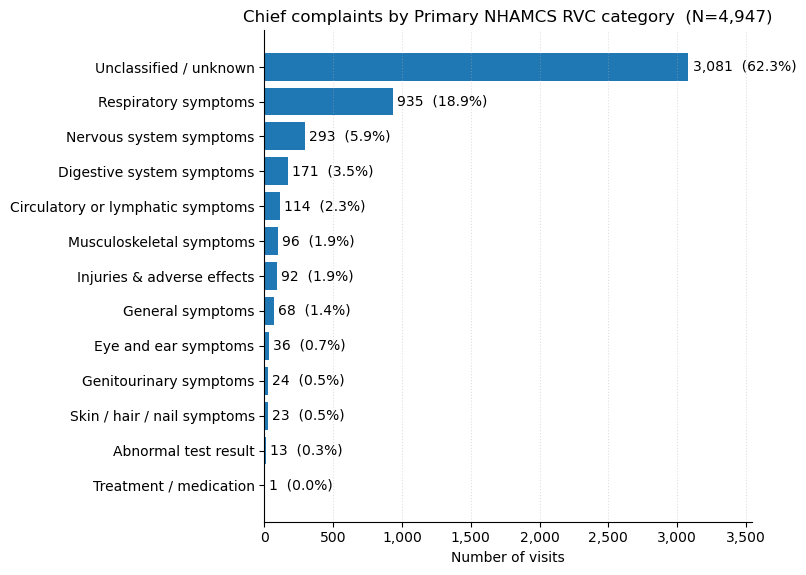

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

def plot_rvc_hist(df: pd.DataFrame,
                  col: str = "rvc_text",
                  title: str | None = "Chief complaints by Primary NHAMCS RVC category",
                  outfile_stem: str = "rvc_histogram",
                  sort_desc: bool = True,
                  annotate: bool = True):
    """
    Plot a horizontal frequency bar chart of df[col].
    Saves PNG+PDF (300 dpi) and returns (fig, ax, counts Series).
    """
    # 1) prepare counts
    s = (df[col].astype("string")
                .str.strip()
                .fillna("Unclassified / unknown"))
    counts = s.value_counts()
    if sort_desc:
        counts = counts.sort_values(ascending=False)
    total = int(counts.sum())
    pct = counts / total * 100.0

    # 2) figure
    h = max(4.0, 0.45 * len(counts))  # scale height with #categories
    fig, ax = plt.subplots(figsize=(8, h))
    y = np.arange(len(counts))

    ax.barh(y, counts.values)
    ax.set_yticks(y)
    ax.set_yticklabels(counts.index)
    ax.invert_yaxis()  # largest at top

    # axes labels / title
    ax.set_xlabel("Number of visits")
    if title:
        ax.set_title(f"{title}  (N={total:,})")

    # tidy look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="x", linestyle=":", alpha=0.4)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

    # 3) annotate bars with count and percent
    if annotate:
        xmax = counts.values.max() if len(counts) else 1
        pad = max(1, int(0.01 * xmax))
        for i, (v, p) in enumerate(zip(counts.values, pct.values)):
            ax.text(v + pad, i, f"{v:,}  ({p:.1f}%)", va="center")

        # extend xlim to fit labels
        ax.set_xlim(0, xmax * 1.15)

    fig.tight_layout()

    # 4) save
    outdir = Path("./")
    png = outdir / f"{outfile_stem}.png"
    pdf = outdir / f"{outfile_stem}.pdf"
    fig.savefig(png, dpi=300, bbox_inches="tight")
    fig.savefig(pdf, dpi=300, bbox_inches="tight")

    return fig, ax, counts

# ---- run
fig, ax, counts = plot_rvc_hist(df_out, col="rvc_text", outfile_stem="MIMIC_RVC_distribution")

I think most of the unclassified / unknowns are ones that just didn't have a CC because they transferred or something, but should confirm? 

also, we should consider all the secondary classifications too (ie. if they had nervous system symptoms as a secondary RVC, they should also be counted)

need some manual review of these to ensure they are working as expected